In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.preprocessing as sk_pre
import sklearn.decomposition as sk_dec
import sklearn.model_selection as sk_mos
import sklearn.neural_network as sk_nn
import sklearn.linear_model as sk_ln
import yaml
import networkx as nx
import re

from dataclasses import dataclass

In [22]:
maestro_data = pd.read_csv("../data/maestro-calculated.csv", low_memory=False)
# maestro_data = maestro_data[(maestro_data["workflow_name"] == "securitization-flow")]

In [23]:
jobs = maestro_data["job_name"].unique()
business_day = maestro_data["business-day"].unique()
workflows = maestro_data["workflow_name"].unique()

strategic_flow = maestro_data.loc[maestro_data["workflow_name"] == "strategic-flow"]
strategic_jobs = strategic_flow["job_name"].unique()
securitization_flow = maestro_data.loc[maestro_data["workflow_name"] == "securitization-flow"]
securitization_jobs = securitization_flow["job_name"].unique()

In [24]:
means = {}
for job in maestro_data["job_name"].unique():
    current_job_times = maestro_data[maestro_data["job_name"] == job]["processing-time"]

    q05, q95 = current_job_times.quantile([0.05, 0.95])
    cut = current_job_times.loc[(current_job_times >= q05) & (current_job_times <= q95)]
    mean = cut.mean()
    std = cut.std()
    median = cut.median()
    means[job] = mean

    maestro_data.loc[maestro_data["job_name"] == job, "processing-time"] = (current_job_times - mean) / std

In [25]:
path = "run-b3-securitization","run-sec-tactical-staging","start-securitization-batch","init-securitization-batch","skip-regional-batches","complete-b3-strategic-batch"

In [26]:
sum([means[job] for job in path])

1159.150370796026

(array([33., 27., 51., 48., 22., 19., 28., 20., 25., 23., 24., 34., 32.,
        36., 32., 26., 23., 24., 40., 19., 19., 18., 20.,  9., 13.,  8.,
         6.,  4.,  8.,  2.,  1.,  3.,  2.,  3.,  1.,  0.,  3.,  0.,  3.,
         1.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([-1.45636376, -1.34014723, -1.2239307 , -1.10771417, -0.99149765,
        -0.87528112, -0.75906459, -0.64284806, -0.52663154, -0.41041501,
        -0.29419848, -0.17798195, -0.06176543,  0.0544511 ,  0.17066763,
         0.28688416,  0.40310068,  0.51931721,  0.63553374,  0.75175027,
         0.86796679,  0.98418332,  1.10039985,  1.21661638,  1.3328329 ,
         1.44904943,  1.56526596,  1.68148249,  1.79769901,  1.91391554,
         2.03013207,  2.1463486 ,  2.26256512,  2.37878165,  2.49499818,
         2.61121471,  2.72743123,  2.84364776,  2.95986429,  3.07608082,
         3.19229734,  3.30851387,  3.4247304 ,  3.54094693,  3.65716345,
         3.77337998,  3.88959651,  4.00581304,  4.12202956,

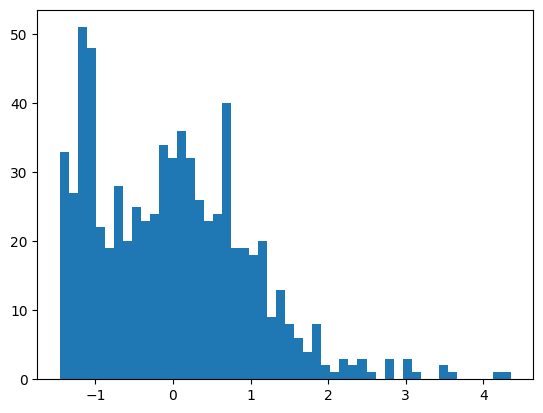

In [202]:
plt.hist(maestro_data[maestro_data["job_name"] == "run-data-staging"]["processing-time"], bins=50)

In [12]:
maestro_data.columns

Index(['api-version', 'processing-location', 'total-time', 'kafka_offset',
       'correlation-id', 'waiting-time', 'rd-run-id', 'skip-mdl-out',
       'parent_uid', 'rules-branch', 'skip-mdl-landing', 'chf-usd-rate',
       'setenv', 'ib-run-id', 'regulatory-authority', 'pb-run-id',
       'regulatory-approaches', 'workflow_name', 'business-date', 'cmd_time',
       'skip-ler', 'uid', 'approach', 'failed-job-status', 'scenario-workflow',
       'process-flag', 'source-type', 'batch-instance-seq', 'hac-run-id',
       'processing-time', 'as-of-datetime', 'business_date', 'batch-workflow',
       'as-of-date', 'business-day', 'job_name', 'flow-type', 'bsinp-run-id'],
      dtype='object')

run-lvr-securitization, has no entries for BD == BD0
run-lvr-securitization, has no entries for BD == BD2
run-lvr-securitization, has no entries for BD == BD3
run-lvr-securitization, has no entries for BD == BD4


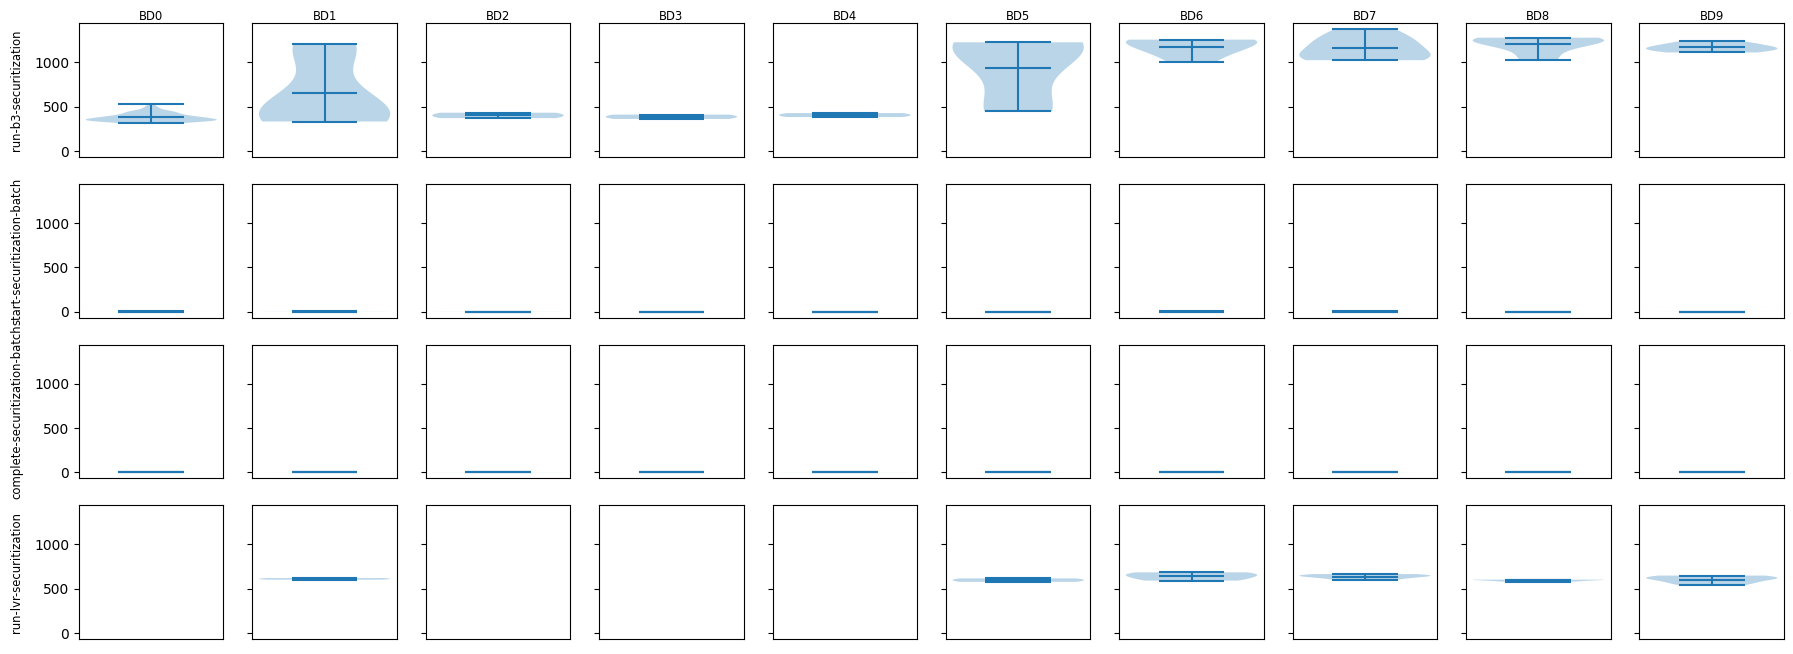

In [76]:
tasks = [6, 4, 17, 19]
COLUMN_NAME = "event-processing-time"

fig, ax = plt.subplots(len(tasks), 10, figsize=(2*len(business_day), 2*len(tasks)), sharey=True, sharex=True)
for j, task in enumerate(tasks):
    job = jobs[task]
    for i, bd in enumerate([f"BD{i}" for i in range(10)]):
        ax[j, i].xaxis.set_visible(False)
        arr = maestro_data.filter(like=COLUMN_NAME)[(maestro_data["job_name"] == job) & (maestro_data["business-day"] == bd)]
        nparr = arr.to_numpy()
        try:
            q01, q99 = np.quantile(nparr, 0.05), np.quantile(nparr, 0.95)
            ax[j, i].violinplot(arr[(q01 <= arr[COLUMN_NAME]) & (arr[COLUMN_NAME] <= q99)], range(1), showmeans=True)
        except:
            print(f"{job}, has no entries for BD == {bd}")

for ax_, row in zip(ax[:, 0], tasks):
    ax_.annotate(jobs[row], 
        xy=(0, 0.5), xytext=(-ax_.yaxis.labelpad, 0),
        xycoords=ax_.yaxis.label, textcoords='offset points',
        size='small', ha='right', va='center',
        rotation=90.0
    )

for ax_, col in zip(ax[0, :], range(10)):
    ax_.annotate(f"BD{col}",
        xy=(0.5, 1), xytext=(0, 5),
        xycoords="axes fraction", textcoords='offset points',
        size='small', ha='center', va='center',
    )

In [117]:
@dataclass(order=False)
class Job:
    q05: float
    q95: float
    mean: float
    len: float
    score: float
    job: str

    def __str__(self):
        return f"<q05={self.q05: 9.2f} q95={self.q95: 9.2f} mean={self.mean: 9.2f} len={self.len: 4d} score={self.score: 9.2f} job={self.job}>"
    
    def __hash__(self) -> int:
        return hash(str(self))


# columns_label = {
#     "skip-mdl-out", "batch-workflow", "flow-type",
#     "rules-branch", "business-day", "batch-instance-seq", "ib-run-id",
#     "hac-run-id", "regulatory-approaches"
# }
columns_label = {
    'regulatory-approaches', 'ib-run-id', 'rules-branch',
    'processing-location-is-eur', 'event-total-time', 'skip-mdl-out',
    'setenv', 'bsinp-run-id', 'processing-location-is-sec',
    'processing-location-is-pac', 'rd-run-id', 'source-type-is-ib',
    'business-day', 'processing-location-is-ch', 'batch-instance-seq',
    'processing-location-is-ams', 'batch-workflow',
    'pb-run-id', 'source-type-is-pb', 'process-flag', 'flow-type',
    'hac-run-id', 'skip-mdl-landing', 'previous-ratio'
}

In [120]:
trainable_jobs_labelized_nn = set()
trainable_jobs_labelized_lr = set()

for job in jobs:
    labelizer = dict.fromkeys(columns_label, None)
    maestro_cut = maestro_data[list(columns_label) + ["event-processing-time"]][maestro_data["job_name"] == job].copy()
    maestro_times = maestro_cut.pop("event-processing-time").astype(float)

    q05, q95 = maestro_times.quantile(0.05), maestro_times.quantile(0.95)
    cut = maestro_times[(maestro_times >= q05) & (maestro_times <= q95)]
    mean = cut.mean()
    maestro_times /= mean
    if mean == 0:
        print(f'Skipping job: {job}, q05: {q05:.04}, q95: {q95:.04}, mean: {mean:.04}, len: {len(cut)}')
        continue

    for i, item in enumerate(list(columns_label)):
        labelizer[item] = sk_pre.LabelEncoder()
        labelizer[item].fit(list(set(maestro_cut[item])))
        maestro_cut[item] = labelizer[item].fit_transform(maestro_cut[item])

    x_train, x_test, y_train, y_test = sk_mos.train_test_split(maestro_cut, maestro_times)

    nn = sk_nn.MLPRegressor(max_iter=10_000, activation='logistic', batch_size=min(32, len(y_train)), hidden_layer_sizes=[100, 10])
    lr = sk_ln.LinearRegression()
    nn.fit(x_train, y_train)
    lr.fit(x_train, y_train)
    trainable_jobs_labelized_nn.add(Job(q05, q95, mean, len(cut), nn.score(x_test, y_test), job))
    trainable_jobs_labelized_lr.add(Job(q05, q95, mean, len(cut), lr.score(x_test, y_test), job))
    

Skipping job: complete-b3-strategic-batch, q05: 0.0, q95: 0.0, mean: 0.0, len: 400
Skipping job: skip-regional-batches, q05: 0.0, q95: 0.0, mean: 0.0, len: 148
Skipping job: complete-b3-securitization-batch, q05: 0.0, q95: 0.0, mean: 0.0, len: 160
Skipping job: complete-strategic-batch-sec, q05: 0.0, q95: 0.0, mean: 0.0, len: 151


In [115]:
def get_graph(data):
    line = 0.75
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[1].bar(range(len(list(data))), [i.score for i in list(data)], 1)
    ax[1].set_ylim(0, 1)
    ax[1].set_ylabel("$0 \leq R^2 \leq 1$")
    ax[1].set_xlabel("Zadanie")
    ax[1].xaxis.set_ticks(range(len(list(data))))
    ax[1].xaxis.set_ticklabels("")
    x_low, x_high = ax[1].get_xlim()
    ax[1].set_xlim(x_low, x_high)
    ax[1].hlines(line, x_low, x_high, "black", alpha=0.25)


    array = np.clip(np.array([(i.score, i.len) for i in list(data)]), 0, np.inf)
    ax[0].set_xlabel("$0 \leq R^2 \leq 1$")
    ax[0].set_ylabel("Ilość danych do nauki [1]")
    ax[0].scatter(array[:, 0], array[:, 1])
    y_low, y_high = ax[0].get_ylim()
    ax[0].set_ylim(y_low, y_high)
    ax[0].set_xlim(-0.05, 1.05)
    ax[0].vlines(line, y_low, y_high, colors="black", alpha=0.25)
    return fig

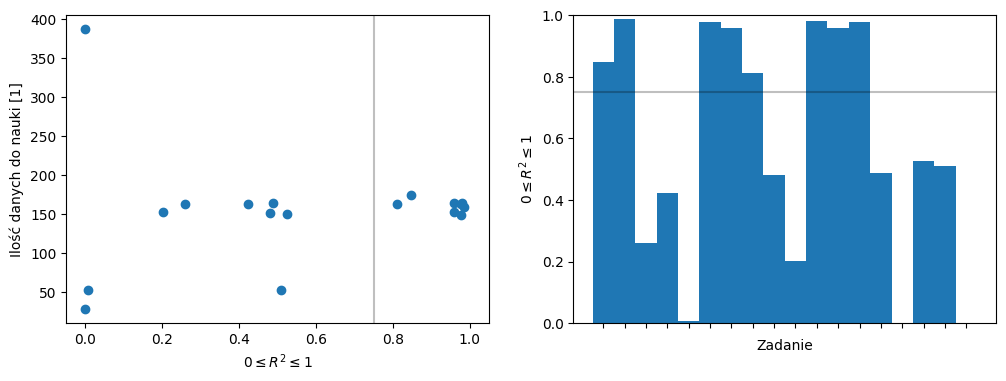

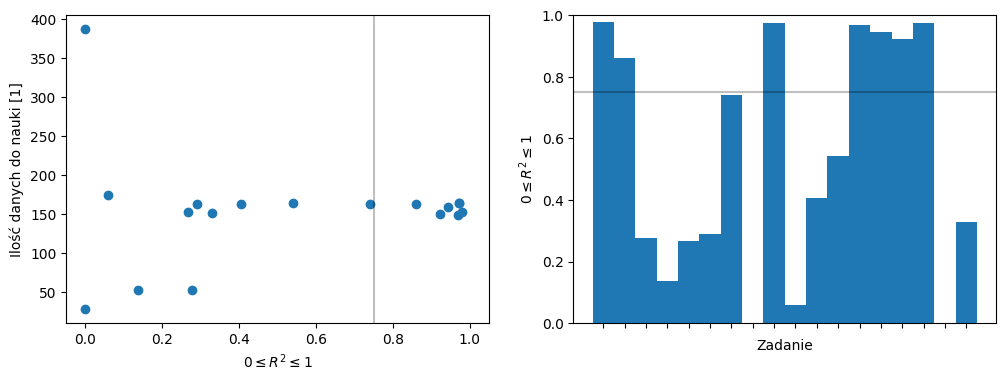

In [121]:
get_graph(trainable_jobs_labelized_nn)
_ = get_graph(trainable_jobs_labelized_lr)

In [88]:
for i in sorted(list(trainable_jobs_labelized_nn), key=lambda a: a.score, reverse=True):
    print(i)

<q05=   133.60 q95=   939.00 mean=   306.91 len= 158 score=     0.97 job=mdl-out-b3-with-securitization>
<q05=    68.52 q95=   941.80 mean=   292.12 len= 169 score=     0.96 job=mdl-out-lech-with-securitization>
<q05=   262.88 q95=  1109.34 mean=   538.74 len= 176 score=     0.95 job=run-b3std-securitization>
<q05=   310.76 q95=  1383.16 mean=   596.77 len= 162 score=     0.94 job=run-b3-securitization>
<q05=   129.56 q95=   674.20 mean=   273.78 len= 171 score=     0.93 job=mdl-out-b3std-with-securitization>
<q05=   149.64 q95=  1267.80 mean=   478.28 len= 175 score=     0.93 job=run-lech-securitization>
<q05=   337.72 q95=   700.28 mean=   491.99 len= 160 score=     0.81 job=run-sec-tactical-staging>
<q05=    75.64 q95=  1072.04 mean=   589.58 len= 175 score=     0.81 job=reload-securitization-tables-lech>
<q05=     0.00 q95=     2.00 mean=     0.53 len= 180 score=     0.78 job=complete-securitization-batch>
<q05=     0.00 q95=     3.00 mean=     0.98 len= 167 score=     0.65 job=sta

In [49]:
# why colon is not in quote in yaml wtf
pattern = re.compile(r"^(\s+[\w-]+: )(.*:.*)$", re.MULTILINE)

with open("../data/securitization-flow.yml") as file:
    content = ""
    for line in file:
        if(match := pattern.match(line)):
            pre, missing_quote = match.groups()
            content += f'{pre}"{missing_quote}"\n'
        else:
            content += line

    securization_flow_yaml = yaml.load(content, yaml.Loader)

In [66]:
securization_flow = nx.DiGraph()
for job_pre in securization_flow_yaml["workflows"][0]["jobs"]:
    if (job := job_pre.get("job", None)) or (job := job_pre.get("nop", None)) or (job := job_pre.get("jobReference", None)):
        name = job.get("name")
        securization_flow.add_node(name, name=name.replace("-", "\n"))
        for precondition in job.get("precondition", []):
            securization_flow.add_node(precondition, name=precondition.replace("-", "\n"))
            securization_flow.add_edge(precondition, job.get("name"))

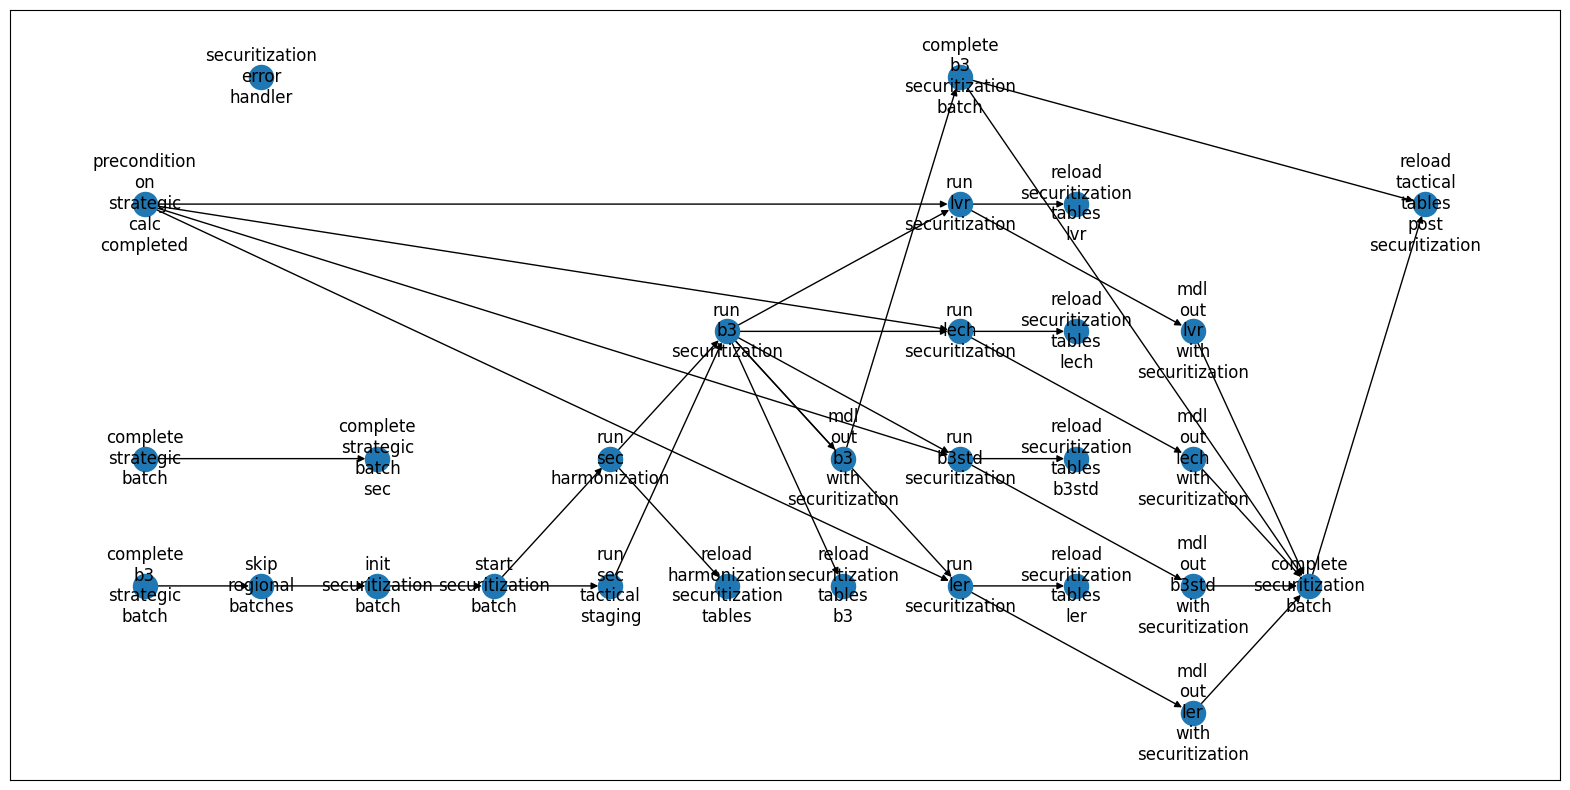

In [71]:
jobs = {"complete-b3-strategic-batch":(0,0),
        "complete-strategic-batch":(0,2),
        "skip-regional-batches":(2,0),
        "init-securitization-batch":(4,0),
        "start-securitization-batch":(6,0),
        "run-sec-tactical-staging":(8,0),
        "run-sec-harmonization":(8,2),
        "reload-harmonization-securitization-tables":(10,0),
        "run-b3-securitization":(10,4),
        "mdl-out-b3-with-securitization":(12,2),
        "reload-securitization-tables-b3":(12,0),
        "complete-strategic-batch-sec":(4,2),
        "run-ler-securitization":(14,0),
        "run-b3std-securitization":(14,2),
        "run-lech-securitization":(14,4),
        "run-lvr-securitization":(14,6),
        "reload-securitization-tables-ler":(16,0),
        "reload-securitization-tables-b3std":(16,2),
        "reload-securitization-tables-lech":(16,4),
        "reload-securitization-tables-lvr":(16,6),
        "complete-b3-securitization-batch":(14,8),
        "mdl-out-ler-with-securitization":(18,-2),
        "mdl-out-b3std-with-securitization":(18,0),
        "mdl-out-lech-with-securitization":(18,2),
        "mdl-out-lvr-with-securitization":(18,4),
        "complete-securitization-batch":(20,0),
        "reload-tactical-tables-post-securitization":(22,6),
        "securitization-error-handler":(2,8),
        "precondition-on-strategic-calc-completed": (0, 6)}

plt.figure(figsize=(20, 10))
pos = nx.kamada_kawai_layout(securization_flow, scale=1)
nx.draw_networkx_nodes(securization_flow,pos=jobs)
nx.draw_networkx_edges(securization_flow, jobs)
_ = nx.draw_networkx_labels(securization_flow, jobs, nx.get_node_attributes(securization_flow, "name"))